<font color="#de3023"><h1><b>REMINDER: MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

#Image Recolorization

With the advent of new ML architectures like U-Nets and Generative Adversarial Networks (GANs), image modification and generation have become cornerstones of contemporary artificial intelligence. Today, we'll be using a GAN to add color to black and white images, and explore how the training sets we use affect the success of our recolorizations. 

In this notebook, we will:
* Explore a popular image dataset
* Train a GAN to produce recolorized images 
* See how our net performs on images from American history
 
 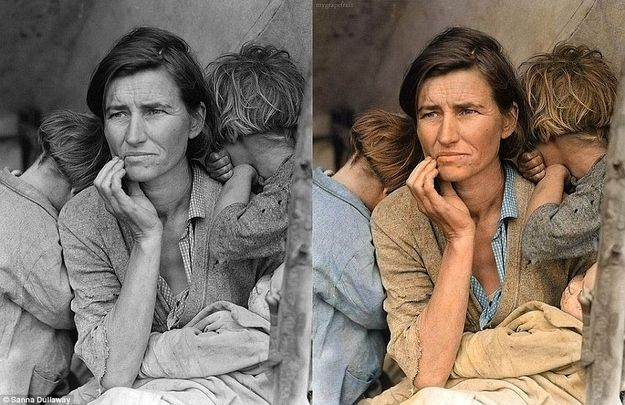

 *Image credit: Sanna Dullaway*
 Let's get started!


As Inspirit AI and Human Rights scholars, we've been asked by the Library of Congress to help with a tricky AI problem. They're worried that old black and white images of culturally important moments are uninteresting to the general public. To get people interested in their work, they've asked us to help them recolorize these old images to bring them back to life for a new fundraising campaign. Let's see what we can do!

In [ ]:
#@title Run to load data and helper functions
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip -d Flicker8k_Dataset
!pip install fastai --upgrade

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda")

SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")



#load pretrained net

!gdown --id 159uYNehcN7zQ3LCIstfMXd5IlQBC-o21

#load LoC data
!gdown --id 1alvVV-XvA-mhFD32eJAxv3BRyuIawcn6
!unzip /content/LoC_Images -d LoC_Images
test_dl = make_dataloaders(paths = glob.glob("LoC_Images/*.jpg"), split='val')

Streaming output truncated to the last 5000 lines.
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3441531010_8eebbb507e.jpg  
  inflating: Flicker8k_Dataset/Flicker8k_Dataset/3441701164_6dbbdf1bce.jpg  
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3441701164_6dbbdf1bce.jpg  
  inflating: Flicker8k_Dataset/Flicker8k_Dataset/3442138291_3e75f4bdb8.jpg  
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3442138291_3e75f4bdb8.jpg  
  inflating: Flicker8k_Dataset/Flicker8k_Dataset/3442242092_e579538d82.jpg  
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3442242092_e579538d82.jpg  
  inflating: Flicker8k_Dataset/Flicker8k_Dataset/3442272060_f9155194c2.jpg  
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3442272060_f9155194c2.jpg  
  inflating: Flicker8k_Dataset/Flicker8k_Dataset/3442540072_b22ca2410f.jpg  
  inflating: Flicker8k_Dataset/__MACOSX/Flicker8k_Dataset/._3442540072_b22ca2410f.jpg  
  inflating: Flicker8k_Dataset/Flick

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## GAN Overview

First, let's talk about how GANs work! 

The core idea is clever but surprisingly simple: we make two neural networks fight each other!

The **generator** is like an **art forger**: its job is to create realistic-looking fake images. 

The **discriminator** is like a **detective**: its job is to tell the difference between **fake** images created by the generator and **real** images from the training data.

![](https://www.tensorflow.org/tutorials/generative/images/gan1.png) 

Both networks start out terrible at their jobs - but over time, they push each other to get better! The discriminator gets better at telling the generator's images from the real deal, and the generator has to make more realistic fake images so it can trick the discriminator.

The generator **never** sees the training data, so it has to invent brand-new images rather than copying existing ones!

![](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

Now let's load in the Flickr8k photos dataset. **Use the np.random.permutation() function to randomize the indexes, and then divide the dataset into train_idxs and val_idxs. Then, define train_paths and val_paths using these indexes. Work through the code and explain how each line of code works to your classmates.**

In [ ]:
path = "Flicker8k_Dataset/Flicker8k_Dataset"     
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123) 
paths_subset = np.random.choice(paths, 8000, replace=False) # choosing 8000 images randomly
### YOUR CODE HERE ###
indexes = np.random.permutation(8000)
train_idxs = indexes[:6000]# choosing the first 8000 indexes as training set
val_idxs = indexes[6000:] # choosing last 2000 indexes as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
### END ###
print(len(train_paths), len(val_paths))

6000 2000


Let's take a look at some of the images. **What kind of images are these? How do you think the type and variety of images will affect our model? From this sampling, do you see any omissions?**

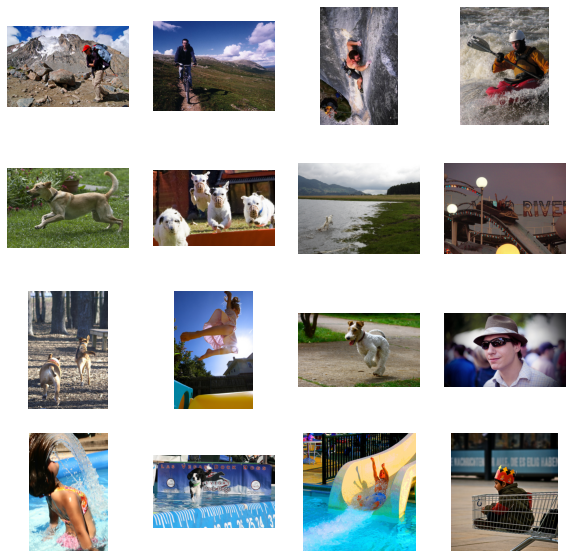

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Splitting into training and validation data. **Use the make_dataloaders function to set up the validation data, use split='val' and the val_paths you had defined before. Why do we randomize the data? What kind of biases can emerge from us neglecting to randomize the data?** 

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
### YOUR CODE HERE ###
val_dl = make_dataloaders(paths=val_paths, split='val')
### END ###

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
375 125


We're going to be using a U-Net as the generator of our GAN. It's a bit complicated, so let's take a look at a diagram and the code.


![unet](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/unet.png?raw=1)

*Image Credit: Meoin Shariatnia*

Don't worry, you're not expected to fully understand this code! Just take a few minutes reading through it to see if you can understand which parts map onto different sections of the model above.

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

For the discriminator half of the GAN, we're using a standard `PatchDiscriminator`, which is implimented in the hidden code at the top. Let's take a second to look at the different blocks. **Advanced: can you diagram out each layer based on the variables displayed?**

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

Now let's introduce our main model:

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

Now we can write a function to train the model and set it up! Recall that one epoch is one cycle through the entire training dataset. **Define the two for loops we should iterate over, the outer loop should be iterating over each epoch, and the inner loop should be iterating over each item in the dataset.**

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs): ### YOUR CODE HERE: iterate over all the epochs, and define each epoch with the variable e.
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl): ### YOUR CODE HERE: iterate over all the training data, using the tqdm function and the variable data
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


As it turns out, we don't necessarily need to build a new U-Net from scratch. We can transform a prebuild resnet (a common image processing neural network) into a UNet by changing some of its dimensions!

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

As it turns out, this U-Net/GAN combined architecture takes a loooooong time to trian. Let's bring in a pretrained version of the network and then run it for one epoch to see some results on the validation images!

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("/content/final_model_weights_4_epochs.pt", map_location=device))
model = MainModel(net_G=net_G)

model initialized with norm initialization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/375 [00:00<?, ?it/s]


Epoch 1/1
Iteration 200/375
loss_D_fake: 0.45720
loss_D_real: 0.47482
loss_D: 0.46601
loss_G_GAN: 1.60305
loss_G_L1: 9.83235
loss_G: 11.43540


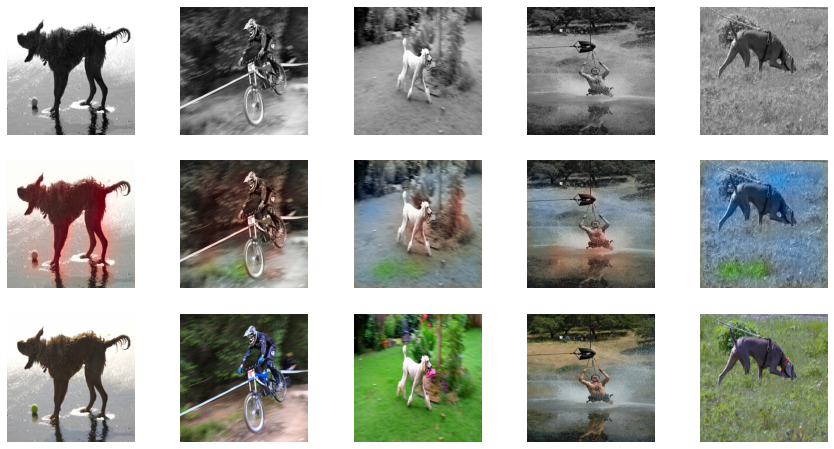

In [ ]:
train_model(model, train_dl, 1)

Now let's see how it performas on photographs from American history. What patterns do you notice? Where do the colors fail?

In [ ]:
for data in tqdm(test_dl):
  try:
    visualize(model, data, save=False)
  except:
    pass

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


One thing I notice is that lanscapes are depicted with much brighter colors than their actual tones. **How might this affect that way we think about the history of events like the Dustbowl? What other features (cultural dress? skin tone? domiciles?) might be inaccurately depicted -- how does this affect the success of our network?**